# **Course**: Deep Learning

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/)

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)

# **Assignment 06:** Semantic segmentation

In this assignment we will perform semantic segmentation using two different networks:
- U-Net
- DeepLabV3+

In this context, you will perform the following experiments:

<center>

|  Experiment  |    Model   |      Loss     | Data augmentation | Metric |
|:------------:|:----------:|:-------------:|:-----------------:|:------:|
|       1      |    U-Net   | Cross entropy |         No        |  mIoU  |
|       2      |    U-Net   |     Focal ($\gamma=2$)|         No        |  mIoU  |
|       3      | DeepLabV3+ | Cross entropy |         No        |  mIoU  |
|       4      | DeepLabV3+ | Cross entropy |        Yes        |  mIoU  |
| 5 (optional) | DeepLabV3+ |     Focal ($\gamma=2$)|        Yes        |  mIoU  |
| 6 (optional) | DeepLabV3+ |     Focal ($\gamma=3$)|        Yes        |  mIoU  |
| 7 (optional) | DeepLabV3+ |     Focal ($\gamma=4$)|        Yes        |  mIoU  |
|  8 (optional)      |    U-Net   |     Focal ($\gamma=2$)|         Yes        |  mIoU  |

</center>

- Run each experiment.
- Compute the metrics for the test set using all trained models.
- Generate the Wand report.
- Show your visual results in the following format:

<center>

| Input image | Reference | Prediction Exp 1 | Prediction Exp 2 | Prediction Exp 3 | Prediction Exp 4 | Colormap |
|:------------:|:----------:|:-------------:|:-----------------:|:------:|:------:|:------:|
|  Patch 1 |      |     |     |      |    |      |
|  Patch 2 |      |     |     |      |    |      |  

</center>

See an example:
<center>

<img src="https://drive.google.com/uc?export=view&id=1JaNRFENs5GCucERpk1copi_GavHSQLFj" width=800 img>

</center>

- Comment on your results from the quantitative (metrics: IoU per class and mean IoU) and qualitative (visualization of predictions) point of views, as well as the training curves.

For this purpose, we will work with the ISPRS [2D Semantic Labeling benchmark - Vaihingen](https://www.isprs.org/education/benchmarks/UrbanSemLab/2d-sem-label-vaihingen.aspx) dataset.

The dataset contains 33 patches (of different sizes), each consisting of a true orthophoto (TOP), extracted from a larger TOP mosaic, and a Digital Surface Model (DSM).

<center>
<img width=500 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/overview_tiles.jpg?width=398.4830805134189&height=500" img>
</center>

Labelled ground truth is provided for all areas. An example of a patch from the dataset, where a) true orthophoto, b) DSM, and c) ground truth.

<center>
<img width=600 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/examples_top_dsm_gts.png?width=500&height=196.7930029154519" img>
</center>

**In this assignment we will work only with the RGB images.**

To create the train, validation and test sets, we will follow the benchmark guidelines:

<center>
<img width=600 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/table_label_contest_image_overview.png?width=500&height=397.5490196078431" img>
</center>

So, the areas for training and testing are the following:

<center>

|  Set  |   Areas   |
|-------|-----------|
| Train | 1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37 |
| Test  | 2,4,6,8,10,12,14,16,20,22,24,27,29,31,33,35,38 |

</center>

## **Mount Google Drive to Google Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change **this path** to the **path of a folder** in your Google Drive to storage the files associated to this session (trained model, figures for visualization, etc.)

In [2]:
# %cd drive/MyDrive/PATH/TO/YOUR/FOLDER
%cd drive/MyDrive/Colabs/DeepLearning_course/Lab_07

/content/drive/MyDrive/Colabs/DeepLearning_course/Lab_07


## **Load packages and data**

In [2]:
# Management of files
import os
from os.path import exists, join

# Tensorflow and Keras
from tensorflow.keras.callbacks import ModelCheckpoint, \
                                       EarlyStopping
from tensorflow.keras.metrics import OneHotMeanIoU, OneHotIoU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

# Working with arrays
import numpy as np

# External files with functions to load the dataset,
# create a CNN model, and a data generator.
from importlib import reload
import utils
import models_deeplab
import models_unet
import data_generator
import losses
# Useful to reload modified external files without need
# of restarting the kernel. Just run again this cell.
reload(utils)
reload(models_deeplab)
reload(models_unet)
reload(data_generator)
reload(losses)

from utils import *
from models_deeplab import *
from models_unet import *
from data_generator import *
from losses import *

**Variables**

The variable `color2index` is a dictionary to map the RGB colors (`(r,g,b)`) to a single integer (`int`)

In [3]:
PROJECT_DIR = "." # os.getcwd()
SEED = 42
color2index = {(255,255,255) : 0,
               (0  ,0  ,255) : 1,
               (0  ,255,255) : 2,
               (0  ,255,0  ) : 3,
               (255,255,0  ) : 4,
               (255,0  ,0  ) : 5
               }
n_classes = len(color2index)

BATCH_SIZE = 8
PATCH_SIZE = 256
STEP_SIZE = 256
EPOCHS = 200

### **Reading the dataset**

The function `read_vaihingen` is defined in the `utils.py` file.

In [4]:
# Path to the dataset folder in Google Drive
DATA_PATH = join(PROJECT_DIR, "ISPRS_semantic_labeling_Vaihingen")

list_top, list_gts = read_vaihingen(DATA_PATH)

### **Train, Validation and Test sets**

The function `train_val_test_vaihingen` is defined in the `utils.py` file.

In [5]:
splits = train_val_test_vaihingen(list_top,
                                  list_gts,
                                  val_size=0.25,
                                  seed=SEED)

For sanity check, let's see the number of classes in each image.

The function `print_info` is defined in the `utils.py` file.

**This code might take a few minutes to be executed (~ 4 min. in Colab).**

In [6]:
# Train
print("Train:")
print_info(splits["top_train"],splits["gts_train"])

# Validation
print("\nValidation:")
print_info(splits["top_val"],splits["gts_val"])

# Test
print("\nTest:")
print_info(splits["top_test"],splits["gts_test"])

Train:
TOP:top_mosaic_09cm_area34.tif , GT:top_mosaic_09cm_area34.tif , N:5
TOP:top_mosaic_09cm_area26.tif , GT:top_mosaic_09cm_area26.tif , N:6
TOP:top_mosaic_09cm_area30.tif , GT:top_mosaic_09cm_area30.tif , N:5
TOP:top_mosaic_09cm_area21.tif , GT:top_mosaic_09cm_area21.tif , N:5
TOP:top_mosaic_09cm_area3.tif , GT:top_mosaic_09cm_area3.tif , N:5
TOP:top_mosaic_09cm_area5.tif , GT:top_mosaic_09cm_area5.tif , N:5
TOP:top_mosaic_09cm_area32.tif , GT:top_mosaic_09cm_area32.tif , N:6
TOP:top_mosaic_09cm_area37.tif , GT:top_mosaic_09cm_area37.tif , N:5
TOP:top_mosaic_09cm_area11.tif , GT:top_mosaic_09cm_area11.tif , N:5
TOP:top_mosaic_09cm_area28.tif , GT:top_mosaic_09cm_area28.tif , N:6
TOP:top_mosaic_09cm_area1.tif , GT:top_mosaic_09cm_area1.tif , N:6
TOP:top_mosaic_09cm_area7.tif , GT:top_mosaic_09cm_area7.tif , N:5

Validation:
TOP:top_mosaic_09cm_area17.tif , GT:top_mosaic_09cm_area17.tif , N:5
TOP:top_mosaic_09cm_area23.tif , GT:top_mosaic_09cm_area23.tif , N:6
TOP:top_mosaic_09cm_ar

## **Data Generator**

Requirements of the model:

- **Input:** Image $[height×width×bands]$
- **Output:** Image $[height×width×classes]$

As the images are too big, we will extract patches with a size $[p×p]$ and step (stride) $s$.

<center>
<img src="https://drive.google.com/uc?export=view&id=1UYrpG-sD_UGCRR7Ras73THF-sbqQoGTu" width=100 img>
</center>



**Recommendation:** Use [Pillow](https://pillow.readthedocs.io/en/stable/) to reduce processing time in reading and cropping the image, because it just loads the part of the image specified by the method [crop](https://pillow.readthedocs.io/en/stable/reference/ImageOps.html?highlight=crop#PIL.ImageOps.crop) when it is converted to a numpy array (_np.asarray_).

```python
# Just reading the header of the image with its information
data = Image.open(path)
# Cropping the area of the image
data = data.crop((x, y, x+patch_size, y+patch_size)
# Loads only the cropped area of the image
data = np.asarray(data)
```

For sanity check, verify the output of the data generator:

The `DataGenerator` class is defined in the `data_generator.py` file.

The following data generators **are not using data augmentation**. Check the `data_generator.py` file to enable the data augmentation option.

In [7]:
data_gen_train = DataGenerator(batch_size=BATCH_SIZE,
                               patch_size=PATCH_SIZE,
                               step_size=STEP_SIZE,
                               list_top=splits["top_train"],
                               list_gts=splits["gts_train"],
                               n_classes=n_classes,
                               colormap_gt=color2index
                               )

data_gen_val = DataGenerator(batch_size=BATCH_SIZE,
                             patch_size=PATCH_SIZE,
                             step_size=STEP_SIZE,
                             list_top=splits["top_val"],
                             list_gts=splits["gts_val"],
                             n_classes=n_classes,
                             colormap_gt=color2index
                             )

In [8]:
print("Number of patches for training: {}".format(len(data_gen_train)*BATCH_SIZE))

print("\nNumber of patches for validation: {}".format(len(data_gen_val)*BATCH_SIZE))

Number of patches for training: 976

Number of patches for validation: 352


In [9]:
a, b = data_gen_train[0]

In [10]:
a.shape, b.shape

((8, 256, 256, 3), (8, 256, 256, 6))

The function `show_batch` is defined in the `utils.py` file.

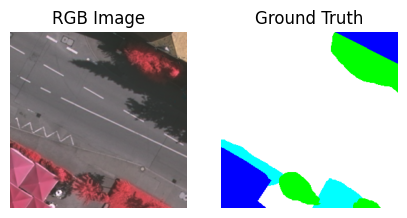

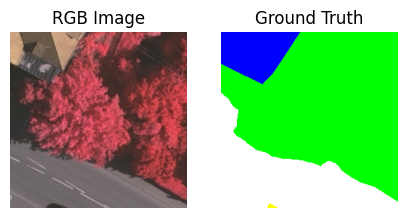

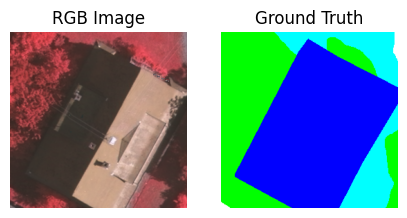

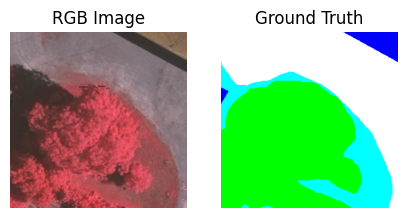

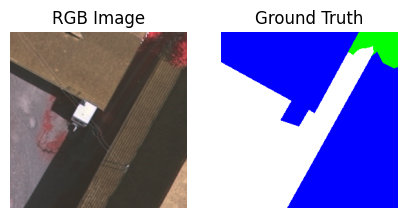

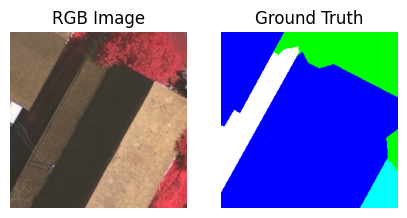

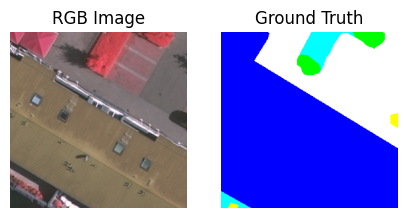

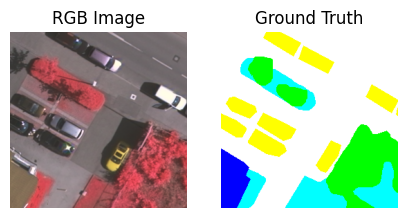

In [11]:
imgs, labels = data_gen_train[0]
show_batch(imgs, labels, color2index)

## **U-Net**


We will use the U-Net model for multiclass semantic segmentation.

For this purpose, we have the following functions in the file **`models_unet.py`**:

- **`conv_block`**: convolutional block with only multiple convolutions.
- **`downsampling`**: downsampling block with a series of convolutions, a max pooling and dropout layers.
- **`upsampling`**: upsampling block with a transpose convolution, concatenate a feature map, dropout and a series of convolutions.

For PyTorch, you can use the following U-Net implementations: [PyTorch UNet](https://github.com/milesial/Pytorch-UNet), [PyTorch Lightning UNet
](https://github.com/hiepph/unet-lightning)

_Notice that the original model has a bottleneck area with **1024** features, we are only using **512** for this assignment._

This is a U-Net with cross entropy loss and one-hot mean IoU as metric to be computed during training.

In [20]:
unet = get_unet(img_size=PATCH_SIZE,
                n_classes=n_classes)

unet.compile(optimizer=Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy",
                      OneHotMeanIoU(num_classes=n_classes,
                                    name="iou")])

### **Visualization**

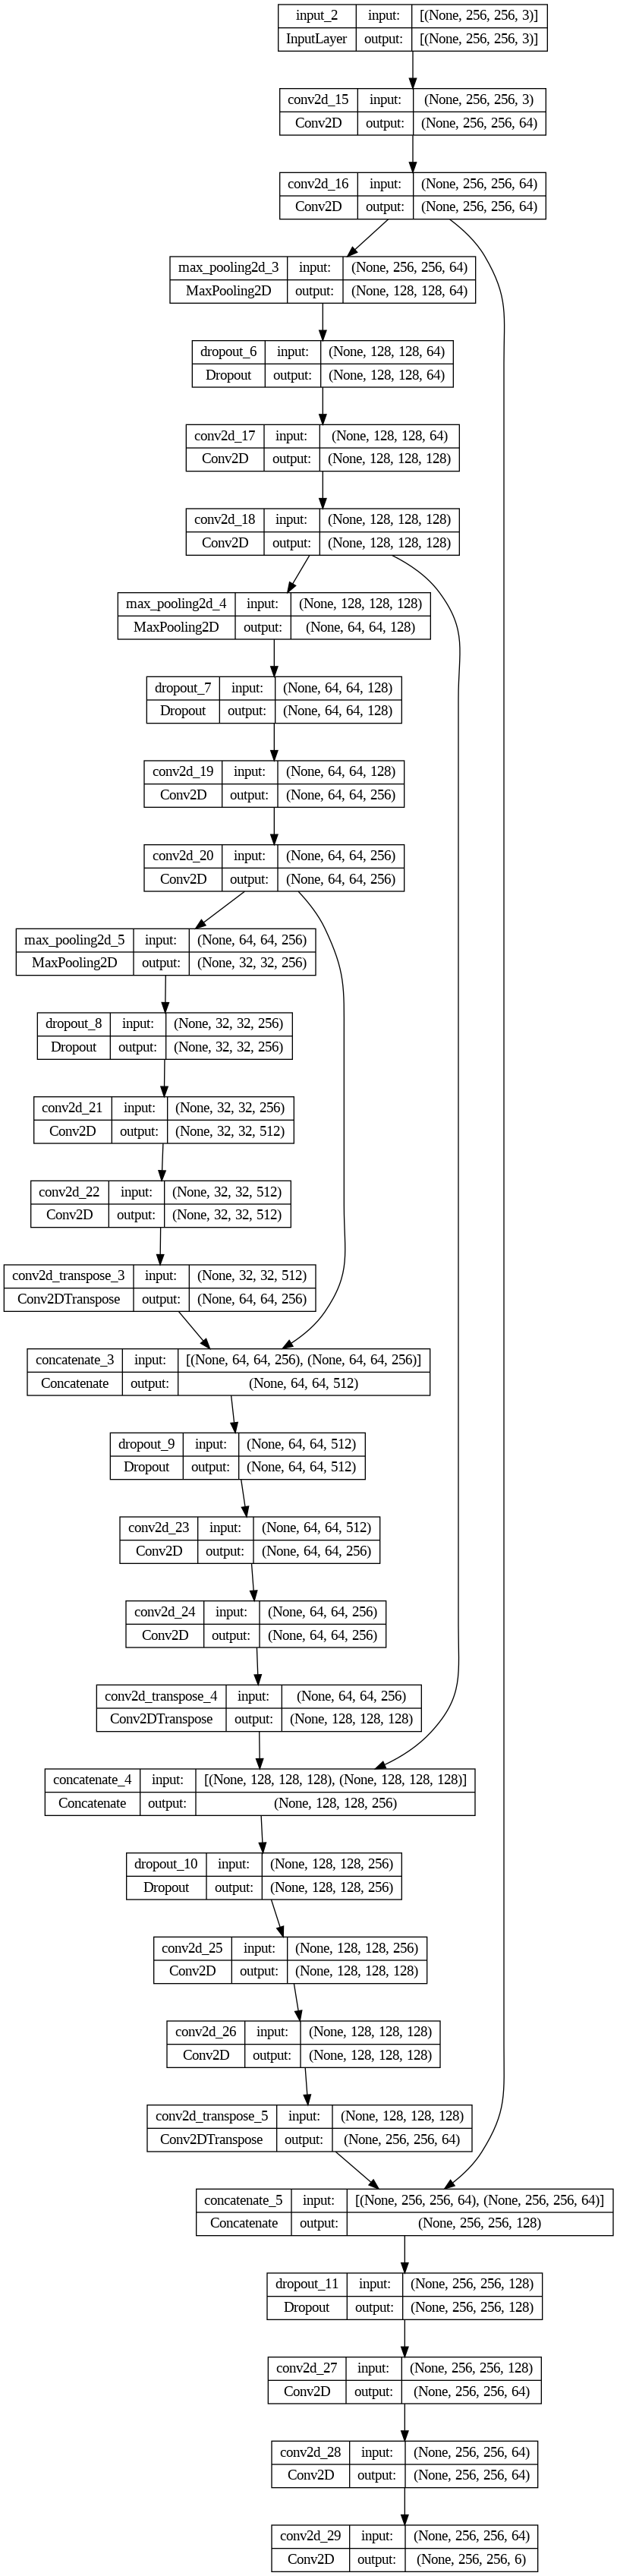

In [21]:
plot_model(unet, to_file="unet.png", show_shapes=True)

## **DeepLabV3+**

We will use the DeepLabV3+ model for multiclass semantic segmentation.

For this purpose, we have the following functions in the file **`models_deeplab.py`**:

- **`conv_bn_block`**: convolutional layer with batch normalization.
- **`DilatedSpatialPyramidPooling`**: creates an atrous spatial pyramid pooling.

This is a DeepLabV3+ with focal loss ($\gamma=2$) and one-hot mean IoU as metric to be computed during training.

In [22]:
deeplab = get_deeplabv3plus(img_size=PATCH_SIZE,
                            n_classes=n_classes)

deeplab.compile(optimizer=Adam(),
                loss=categorical_focal_loss(gamma=2),
                metrics=["accuracy",
                         OneHotMeanIoU(num_classes=n_classes,
                                       name="iou")])

94765736/94765736 [==============================] - 0s 0us/step


### **Visualization**

In [23]:
plot_model(deeplab, to_file="deeplabv3.png", show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

# **Recommendations**

## **Data augmentation**

You can use any data augmentation library in this assignment. This is an example using Albumentations:

```python
from albumentations import (Compose, HorizontalFlip,
                            RandomRotate90, VerticalFlip,
                            ShiftScaleRotate)

def augmentation():
    return Compose([HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.5),
                    RandomRotate90(p=0.5),
                    ShiftScaleRotate(shift_limit=0.01,
                                     scale_limit=0,
                                     rotate_limit=5, p=0.5),
                   ], p = 1)

```

## **Compute mean IoU**

To compute the `IoU` and `mean IoU`, you can use the functions from Keras: `OneHotMeanIoU` and `OneHotIoU`.

You can see an example of how to use them here:

```python
def get_mean_iou(y_true,
                 y_pred,
                 n):
  # Object to compute the mean IoU
  m_iou = OneHotMeanIoU(num_classes=n)
  m_iou.update_state(y_true=y_true,
                     y_pred=y_pred)
  return m_iou.result().numpy()

def get_iou(y_true,
            y_pred,
            n,
            c):
  # Object to compute the IoU for each class
  iou_class = OneHotIoU(num_classes=n,
                        target_class_ids=[c])
  iou_class.update_state(y_true=y_true,
                           y_pred=y_pred)
  # Save IoU for each class
  return iou_class.result().numpy()
```

where `y_true` and `y_pred` are the reference (ground truth) and model's prediction of a patch in one-hot encoding, respectively.

## **Data generator**

The main difference between U-Net and DeepLabV3+ is the usage of a backbone or pre-trained model: ResNet50.

Thus, we have to be careful about input data normalization. The provided data generator in the file `data_generator.py` divides each image patch by 255.

```python
    # Reading the RGB image
    data_image = Image.open(path_image)
    data_image = data_image.crop((x, y,
                                  x + self.patch_size, y + self.patch_size))
    data_image = np.asarray(data_image).astype("float32")

    return data_image/255.0
```

This is **fine for U-Net**; however, for **DeepLabV3+**, **we should remove this**, as the model applies the `preprocess_input` from ResNet50 (see the file `models_deeplab.py`, function `get_deeplabv3plus`, line 103).

```python
from tensorflow.keras.applications.resnet50 import ResNet50, \
                                                   preprocess_input
  # Pre-processing function
  x = preprocess_input(model_input)
  
  # ResNet50 backbone
  resnet50 = ResNet50(weights="imagenet",
                      include_top=False,
                      input_tensor=x)

```

Then, you can create another data generator just for DeepLabV3+ or include a boolean variable in the generator to enable or not the division by 255.